In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls
%cd 'My Drive'/
%ls

In [2]:
%cd 'kaggle_dogs_and_cats'/

/gdrive/My Drive/kaggle_dogs_and_cats


In [3]:
%ls

test/  train/  valid/  vgg16_fine_tuned.h5


In [4]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

Using TensorFlow backend.


In [0]:
train_path = 'train'
test_path = 'test'
valid_path = 'valid'

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=4,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 14269 images belonging to 2 classes.
Found 5606 images belonging to 2 classes.
Found 5135 images belonging to 2 classes.


In [9]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


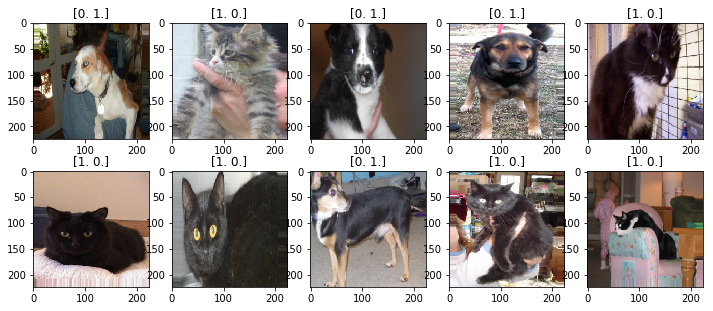

In [10]:
photos, labels = next(iter(train_generator))

plt.figure(figsize=(12, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(photos[i])
  plt.title(labels[i])

In [0]:
test_images, test_labels = next(iter(test_generator))

In [0]:
bin_test_labels = test_labels[:, 0]

In [13]:
bin_test_labels

array([1., 1., 0., 1., 0., 1., 0., 0., 1., 0.], dtype=float32)

In [0]:
from keras.applications.vgg19 import VGG19

In [0]:
vgg19_model = VGG19(include_top=False, input_shape=(224, 224, 3))

In [16]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
for layer in vgg19_model.layers[:-6]:
  layer.trainable = False

In [18]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
for layer in vgg19_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2b154c4e10> False
<keras.layers.convolutional.Conv2D object at 0x7f2b15377ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f2b15440f28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2b153e8908> False
<keras.layers.convolutional.Conv2D object at 0x7f2b153e8e48> False
<keras.layers.convolutional.Conv2D object at 0x7f2b153a2ba8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2b152fd9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f2b152fdb00> False
<keras.layers.convolutional.Conv2D object at 0x7f2b153686a0> False
<keras.layers.convolutional.Conv2D object at 0x7f2b152b67b8> False
<keras.layers.convolutional.Conv2D object at 0x7f2b152e1588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2b15277898> False
<keras.layers.convolutional.Conv2D object at 0x7f2b15277ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f2b152a0320> False
<keras.layers.convolutional.Conv2D object at 0x7f2b152386a0>

In [0]:
model = Sequential()

In [0]:
model.add(vgg19_model)

In [22]:
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(2, activation='softmax'))

W0707 15:45:14.830544 139824406865792 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 45,717,570
Trainable params: 35,132,418
Non-trainable params: 10,585,152
_________________________________________________________________


In [24]:
model.compile(optimizer=Adam(lr=0.0001), loss=categorical_crossentropy, metrics=['accuracy'])

W0707 15:45:18.334631 139824406865792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
history = model.fit_generator(train_generator, 
                    steps_per_epoch=10, 
                    validation_data=valid_generator, 
                    validation_steps=10,
                    verbose=2,
                    epochs=10)

Epoch 1/10
 - 26s - loss: 0.1459 - acc: 0.9300 - val_loss: 0.1467 - val_acc: 0.9250
Epoch 2/10
 - 27s - loss: 0.2104 - acc: 0.8900 - val_loss: 0.2236 - val_acc: 0.9000
Epoch 3/10
 - 27s - loss: 0.2114 - acc: 0.9300 - val_loss: 0.3010 - val_acc: 0.9250
Epoch 4/10
 - 25s - loss: 0.2096 - acc: 0.9200 - val_loss: 0.0609 - val_acc: 1.0000
Epoch 5/10
 - 26s - loss: 0.1335 - acc: 0.9400 - val_loss: 0.2459 - val_acc: 0.9000
Epoch 6/10
 - 24s - loss: 0.2291 - acc: 0.8800 - val_loss: 0.3271 - val_acc: 0.8250
Epoch 7/10
 - 24s - loss: 0.1835 - acc: 0.9300 - val_loss: 0.2499 - val_acc: 0.8750
Epoch 8/10
 - 26s - loss: 0.2729 - acc: 0.8600 - val_loss: 0.1764 - val_acc: 0.9750
Epoch 9/10
 - 25s - loss: 0.1013 - acc: 0.9600 - val_loss: 0.1408 - val_acc: 0.9750
Epoch 10/10
 - 25s - loss: 0.1413 - acc: 0.9500 - val_loss: 0.0794 - val_acc: 0.9750


In [0]:
predictions = model.predict_generator(generator=test_generator,
                                      steps=100,
                                      use_multiprocessing=True,
                                      verbose=1,)

100/100 [==============================] - 246s 2s/step


In [0]:
model.save('vgg16_fine_tuned.h5')